<a href="https://colab.research.google.com/github/chcorophyll/my_deeplearning_cookbook/blob/master/my_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chcorophyll/deep_learning_cookbook.git

Cloning into 'deep_learning_cookbook'...
remote: Enumerating objects: 427, done.
remote: Total 427 (delta 0), reused 0 (delta 0), pack-reused 427
Receiving objects: 100% (427/427), 160.26 MiB | 26.10 MiB/s, done.
Resolving deltas: 100% (207/207), done.
Checking out files: 100% (86/86), done.


In [2]:
!ls

deep_learning_cookbook	sample_data


In [0]:
import os

path_org = os.getcwd()
path_data = os.path.join(path_org, "deep_learning_cookbook")
os.chdir(path_data)

**Quick Draw Cat Autoencoder**

In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Concatenate
from keras.layers import Flatten, Lambda
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras import backend as K
from struct import unpack
import matplotlib.pyplot as plt
import json
import glob
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import Adam
from io import BytesIO
import PIL
from PIL import ImageDraw
from keras.utils import get_file
from IPython.display import clear_output, Image, display, HTML

Using TensorFlow backend.


In [5]:
BASE_PATH ="https://storage.googleapis.com/quickdraw_dataset/full/binary/"
path = get_file("cat", BASE_PATH + "cat.bin")

19578880/19571324 [==============================] - 1s 0us/step


In [6]:
def load_icons(path, train_size=0.85):
    x = []
    with open(path, "rb") as f:
        while True:
            img = PIL.Image.new("L", (32, 32), "white")
            draw = ImageDraw.Draw(img)
            header = f.read(15)
            if len(header) != 15:
                break
            strokes, = unpack("H", f.read(2))
            for i in range(strokes):
                n_points, = unpack("H", f.read(2))
                fmt = str(n_points) + "B"
                read_scaled = lambda: (p // 8 for p in unpack(fmt, f.read(n_points)))
                points = [*zip(read_scaled(), read_scaled())]
                draw.line(points, fill=0, width=2)
            img = img_to_array(img)
            x.append(img)
    x = np.asarray(x) / 255
    return train_test_split(x, train_size=train_size)

x_train, x_test = load_icons(path)
x_train.shape, x_test.shape

((104721, 32, 32, 1), (18481, 32, 32, 1))

In [7]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))
    
    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        left = Conv2D(channels, (3, 3), activation="relu", padding="same")(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding="same")(conc)
        
    x = Dense(channels)(x) # 1X1卷积
    
    for i in range(4):
        x = Conv2D(channels, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
        
    decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

W0711 05:17:33.238167 140289556768640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 05:17:33.276524 140289556768640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 05:17:33.284549 140289556768640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 05:17:33.334200 140289556768640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0711 05:17:33.475361 140289556768640 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 4)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 8)    0           conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
__________

In [8]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train, epochs=100, 
                batch_size=128, shuffle=True, 
                validation_data=(x_test, x_test), 
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

W0711 05:17:36.220582 140289556768640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 104721 samples, validate on 18481 samples


W0711 05:17:40.104225 140289556768640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0711 05:17:40.105605 140289556768640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
104721/104721 [==============================] - 20s 192us/step - loss: 0.6033 - val_loss: 0.5625
Epoch 2/100
104721/104721 [==============================] - 17s 162us/step - loss: 0.4668 - val_loss: 0.4141
Epoch 3/100
104721/104721 [==============================] - 17s 161us/step - loss: 0.3963 - val_loss: 0.3874
Epoch 4/100
104721/104721 [==============================] - 17s 160us/step - loss: 0.3701 - val_loss: 0.3623
Epoch 5/100
104721/104721 [==============================] - 17s 159us/step - loss: 0.3530 - val_loss: 0.3593
Epoch 6/100
104721/104721 [==============================] - 17s 158us/step - loss: 0.3411 - val_loss: 0.3403
Epoch 7/100
104721/104721 [==============================] - 17s 160us/step - loss: 0.3326 - val_loss: 0.3335
Epoch 8/100
104721/104721 [==============================] - 17s 159us/step - loss: 0.3256 - val_loss: 0.3312
Epoch 9/100
104721/104721 [==============================] - 17s 158us/step - loss: 0.3196 - val_loss: 0.3316
Epoch 10/1

In [9]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

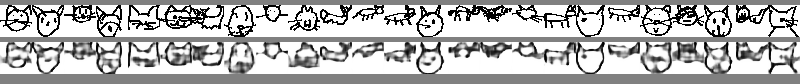

In [10]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile*255, 0, 255)
    return PIL.Image.fromarray(tile)

overview = PIL.Image.new("RGB", (cols*32, 64+20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]),(idx*32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, "png")
display(Image(data=f.getvalue()))

**Icon Autoencoding**

In [0]:
batch_size = 250
latent_space_depth = 64

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0, stddev=1)
    return z_mean + K.exp(z_log_var / 2) * eps

In [12]:
def VariationalAutoEncoder(num_pixels):
    
    input_img = Input(shape=(32, 32, 1))
    
    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation="relu", padding="same")(x)
        right =  Conv2D(channels, (2, 2), activation="relu", padding="same")(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding="same")(conc)
        channels *= 2
        
    x = Dense(channels)(x)
    encoder_hidden = Flatten()(x)
    
    z_mean = Dense(latent_space_depth, activation="linear")(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.0001 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)
    
    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return binary_crossentropy(y_true, y_pred)
    
    def total_loss(y_true, y_pred):
        return reconstruction_loss(y_true, y_pred) + KL_loss(y_true, y_pred)
    
    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_in = Input(shape=(latent_space_depth, ))
    
    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    e_x = Reshape((1, 1, latent_space_depth))(z)
    
    for i in range(5):
        conv = Conv2D(channels, (3, 3), activation="relu", padding="same")
        upsampling = UpSampling2D((2, 2))
        d_x = conv(d_x)
        d_x = upsampling(d_x)
        e_x = conv(e_x)
        e_x = upsampling(e_x)
        channels //= 2
        
    final_conv = Conv2D(1, (3, 3), activation="sigmoid", padding="same")
    auto_decoded = final_conv(e_x)
    decoder_out = final_conv(d_x)
    
    decoder = Model(decoder_in, decoder_out)
    
    auto_encoder = Model(input_img, auto_decoded)
    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    return auto_encoder, decoder

variational_auto_encoder, variational_decoder = VariationalAutoEncoder(x_train.shape[1])
variational_auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 4)    40          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 4)    20          input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 32, 32, 8)    0           conv2d_14[0][0]                  
                                                                 conv2d_15[0][0]                  
__________

In [13]:
variational_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 1, 1, 128)         73856     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 2, 2, 64)          73792     
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 32)          18464     
__________

In [14]:
x_train.shape

(104721, 32, 32, 1)

In [15]:
(x_train.shape[0] % batch_size)

221

In [16]:
x_train_2 = x_train[:-(x_train.shape[0] % batch_size),:,: :] # ???
x_test_2 = x_test[:-(x_test.shape[0] % batch_size),:,: :]
x_train_2.shape, x_test_2.shape

((104500, 32, 32, 1), (18250, 32, 32, 1))

In [17]:
variational_auto_encoder.fit(x_train_2, x_train_2, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_2, x_test_2))

Train on 104500 samples, validate on 18250 samples
Epoch 1/100
104500/104500 [==============================] - 18s 170us/step - loss: 0.4772 - KL_loss: 0.0045 - reconstruction_loss: 0.4727 - val_loss: 0.4304 - val_KL_loss: 0.0080 - val_reconstruction_loss: 0.4225
Epoch 2/100
104500/104500 [==============================] - 16s 150us/step - loss: 0.4072 - KL_loss: 0.0093 - reconstruction_loss: 0.3979 - val_loss: 0.3911 - val_KL_loss: 0.0097 - val_reconstruction_loss: 0.3814
Epoch 3/100
104500/104500 [==============================] - 16s 150us/step - loss: 0.3808 - KL_loss: 0.0100 - reconstruction_loss: 0.3708 - val_loss: 0.3730 - val_KL_loss: 0.0102 - val_reconstruction_loss: 0.3627
Epoch 4/100
104500/104500 [==============================] - 16s 150us/step - loss: 0.3658 - KL_loss: 0.0102 - reconstruction_loss: 0.3556 - val_loss: 0.3608 - val_KL_loss: 0.0104 - val_reconstruction_loss: 0.3504
Epoch 5/100
104500/104500 [==============================] - 16s 150us/step - loss: 0.3540 - 

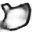

In [18]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(variational_decoder.predict(random_number).reshape(img_width, img_height))

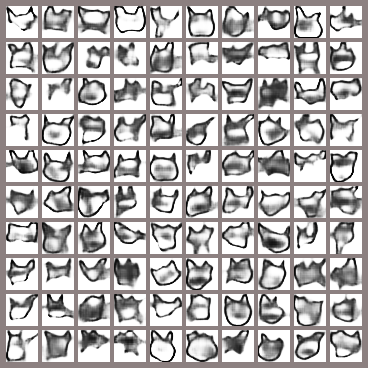

In [19]:
num_cells = 10
img_width = img_height = 32
overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))

for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
        decoded = variational_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [20]:
decoded.shape

(1, 32, 32, 1)

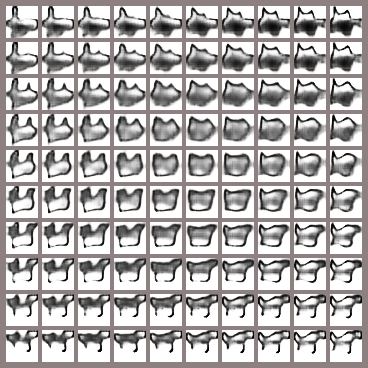

In [21]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[ - (i % 2) * (x - 4.5) / 3 + ((i + 1) % 2) * (y - 4.5) / 3
                            for i in range(latent_space_depth)]])
        decoded = variational_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

**Variational Autoencoder**

In [0]:
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [23]:
def prepare(images, labels):
    images = images.astype("float32") / 255
    n, w, h = images.shape
    return images.reshape((n, w*h)), to_categorical(labels)

train, test = mnist.load_data()
x_train, y_train = prepare(*train)
x_test, y_test = prepare(*test)
img_width, img_height = train[0].shape[1:]

11493376/11490434 [==============================] - 1s 0us/step


In [28]:
type(train)

tuple

In [27]:
train[1]

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [25]:
train[0].shape

(60000, 28, 28)

In [30]:
x_train.shape

(60000, 784)

In [0]:
batch_size = 250
latent_space_depth = 2

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0, stddev=1)
    return z_mean + K.exp(z_log_var / 2) * eps

In [36]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels, ))
    encoder_hidden = Dense(512, activation="relu")(pixels)
    z_mean = Dense(latent_space_depth, activation="linear")(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation="linear")(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return(0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))
    
    def reconstruction_loss(y_true, y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    
    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)
    
    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    
    decoder_hidden = Dense(512, activation="relu")
    reconstruct_pixels = Dense(num_pixels, activation="sigmoid")
    
    decoder_in = Input(shape=(latent_space_depth, ))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)
    
    hidden = decoder_hidden(z)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model(pixels, outputs)
    
    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder
    
auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 512)          401920      input_6[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            1026        dense_11[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 2)            1026        dense_11[0][0]                   
__________________________________________________________________________________________________
lambda_4 (

In [37]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [38]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 53us/step - loss: 213.9580 - KL_loss: 10.9343 - reconstruction_loss: 203.0236 - val_loss: 180.9199 - val_KL_loss: 5.3492 - val_reconstruction_loss: 175.5707
Epoch 2/100
60000/60000 [==============================] - 2s 39us/step - loss: 174.6029 - KL_loss: 4.8514 - reconstruction_loss: 169.7515 - val_loss: 169.5420 - val_KL_loss: 4.7849 - val_reconstruction_loss: 164.7571
Epoch 3/100
60000/60000 [==============================] - 2s 38us/step - loss: 167.7202 - KL_loss: 4.8608 - reconstruction_loss: 162.8594 - val_loss: 166.3485 - val_KL_loss: 5.0351 - val_reconstruction_loss: 161.3134
Epoch 4/100
60000/60000 [==============================] - 2s 38us/step - loss: 165.1644 - KL_loss: 4.9927 - reconstruction_loss: 160.1717 - val_loss: 164.4811 - val_KL_loss: 5.0343 - val_reconstruction_loss: 159.4469
Epoch 5/100
60000/60000 [==============================] - 2s 38us/step - los

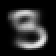

In [39]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height)).resize((56, 56))

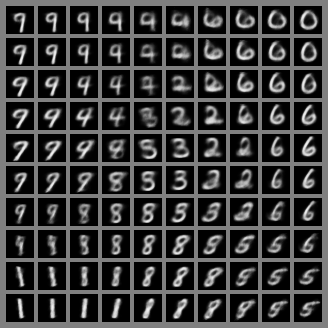

In [40]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[:, 0] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
        vec[:, 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [43]:
def ConditionalVariationalAutoEncoder(num_pixels, num_labels):
    pixels = Input(shape=(num_pixels, ))
    label = Input(shape=(num_labels,), name="label")
    
    inputs = concat([pixels, label], name="inputs")
    
    encoder_hidden = Dense(512, activation="relu", name="encoder_hidden")(inputs)
    
    z_mean = Dense(latent_space_depth, activation="linear")(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation="linear")(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return(0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))

    def reconstruction_loss(y_true, y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)
    
    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    zc = concat([z, label])
    
    decoder_hidden = Dense(512, activation='relu')

    reconstruct_pixels = Dense(num_pixels, activation='sigmoid')
    
    decoder_in = Input(shape=(latent_space_depth + num_labels,))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)
    
    hidden = decoder_hidden(zc)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model([pixels, label], outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

cond_auto_encoder, cond_decoder = ConditionalVariationalAutoEncoder(x_train.shape[1], y_train.shape[1])
cond_auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
inputs (Concatenate)            (None, 794)          0           input_8[0][0]                    
                                                                 label[0][0]                      
__________________________________________________________________________________________________
encoder_hidden (Dense)          (None, 512)          407040      inputs[0][0]                     
__________

In [44]:
cond_auto_encoder.fit([x_train, y_train], x_train, verbose=1, 
                      batch_size=batch_size, epochs=50,
                      validation_data = ([x_test, y_test], x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 54us/step - loss: 196.1017 - KL_loss: 9.2318 - reconstruction_loss: 186.8699 - val_loss: 154.1166 - val_KL_loss: 4.5922 - val_reconstruction_loss: 149.5244
Epoch 2/50
60000/60000 [==============================] - 2s 39us/step - loss: 148.2823 - KL_loss: 4.3599 - reconstruction_loss: 143.9224 - val_loss: 144.0529 - val_KL_loss: 4.2382 - val_reconstruction_loss: 139.8147
Epoch 3/50
60000/60000 [==============================] - 2s 39us/step - loss: 142.7119 - KL_loss: 4.3030 - reconstruction_loss: 138.4089 - val_loss: 141.1862 - val_KL_loss: 4.2256 - val_reconstruction_loss: 136.9606
Epoch 4/50
60000/60000 [==============================] - 2s 39us/step - loss: 140.3650 - KL_loss: 4.2964 - reconstruction_loss: 136.0686 - val_loss: 139.3549 - val_KL_loss: 4.2014 - val_reconstruction_loss: 135.1535
Epoch 5/50
60000/60000 [==============================] - 2s 39us/step - loss: 138

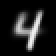

In [47]:
number_4 = np.zeros((1, latent_space_depth+y_train.shape[1]))
number_4[:,4+latent_space_depth] = 1
decode_img(cond_decoder.predict(number_4).reshape(
               img_width, img_height)).resize((56, 56))

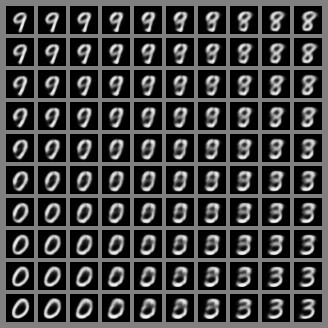

In [48]:
digits = [3, 0, 8, 9]
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
for x in range(num_cells):
    x1 = [x / (num_cells - 1), 1 - x / (num_cells - 1)]
    for y in range(num_cells):
        y1 = [y / (num_cells - 1), 1 - y / (num_cells - 1)]
        for idx, dig in enumerate(digits):
            vec[:, dig + latent_space_depth] = x1[idx % 2] * y1[idx // 2]
        decoded = cond_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

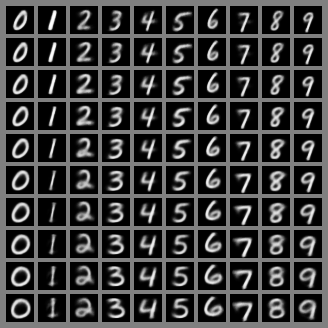

In [49]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

img_it = 0
vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
for x in range(num_cells):
    vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
    vec[:, x + latent_space_depth] = 1
    for y in range(num_cells):
        vec[:, 1] = 3 * y / (num_cells - 1) - 1.5
        decoded = cond_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

**Quick Draw Autoencoder**

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
from struct import unpack
import matplotlib.pyplot as plt
import json
import glob
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from PIL import ImageDraw
from keras.utils import get_file
from IPython.display import clear_output, Image, display, HTML

In [52]:
labels = ['camel', 'cat', 'cow', 'dog', 'horse', 'lion', 'mouse', 'pig', 'rabbit', 'sheep', 'tiger', 'zebra']
labels_to_idx = {label: idx for idx, label in enumerate(labels)}
base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/%s.bin'
paths = {label: get_file(label + '.bin', base_url % label) for label in labels}
paths

25075712/25074676 [==============================] - 1s 0us/step


{'camel': '/root/.keras/datasets/camel.bin',
 'cat': '/root/.keras/datasets/cat.bin',
 'cow': '/root/.keras/datasets/cow.bin',
 'dog': '/root/.keras/datasets/dog.bin',
 'horse': '/root/.keras/datasets/horse.bin',
 'lion': '/root/.keras/datasets/lion.bin',
 'mouse': '/root/.keras/datasets/mouse.bin',
 'pig': '/root/.keras/datasets/pig.bin',
 'rabbit': '/root/.keras/datasets/rabbit.bin',
 'sheep': '/root/.keras/datasets/sheep.bin',
 'tiger': '/root/.keras/datasets/tiger.bin',
 'zebra': '/root/.keras/datasets/zebra.bin'}

In [53]:
def load_icons(paths, train_size=0.85, max_per_class=10000):
    x = []
    y = []
    for label, path in paths.items():
        with open(path, 'rb') as f:
            while True:
                img = PIL.Image.new('L', (32, 32), 'white')
                draw = ImageDraw.Draw(img)
                header = f.read(15)
                if len(header) != 15:
                    break
                strokes, = unpack('H', f.read(2))
                for i in range(strokes):
                    n_points, = unpack('H', f.read(2))
                    fmt = str(n_points) + 'B'
                    read_scaled = lambda: (p // 8 for 
                                           p in unpack(fmt, f.read(n_points)))
                    points = [*zip(read_scaled(), read_scaled())]
                    draw.line(points, fill=0)
                img = img_to_array(img)
                x.append(img)
                y.append(labels_to_idx[label])
                if len(x) % max_per_class == 0:
                    break
    x = np.asarray(x) / 255
    y = np.asarray(y)
    return train_test_split(x, y, train_size=train_size)


x_train, x_test, y_train, y_test = load_icons(paths)
x_train.shape, x_test.shape

((102000, 32, 32, 1), (18000, 32, 32, 1))

In [54]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(4):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(32)(x)

    # at this point the representation is (2, 2, 32) i.e. 128-dimensional

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 32, 32, 4)    40          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 4)    20          input_10[0][0]                   
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 32, 32, 8)    0           conv2d_30[0][0]                  
                                                                 conv2d_31[0][0]                  
__________

In [55]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 102000 samples, validate on 18000 samples
Epoch 1/100
102000/102000 [==============================] - 17s 167us/step - loss: 0.3564 - val_loss: 0.3179
Epoch 2/100
102000/102000 [==============================] - 16s 158us/step - loss: 0.3098 - val_loss: 0.3000
Epoch 3/100
102000/102000 [==============================] - 16s 159us/step - loss: 0.2963 - val_loss: 0.2897
Epoch 4/100
102000/102000 [==============================] - 16s 156us/step - loss: 0.2877 - val_loss: 0.2861
Epoch 5/100
102000/102000 [==============================] - 16s 156us/step - loss: 0.2814 - val_loss: 0.2770
Epoch 6/100
102000/102000 [==============================] - 16s 156us/step - loss: 0.2763 - val_loss: 0.2721
Epoch 7/100
102000/102000 [==============================] - 16s 156us/step - loss: 0.2724 - val_loss: 0.2668
Epoch 8/100
102000/102000 [==============================] - 16s 156us/step - loss: 0.2692 - val_loss: 0.2680
Epoch 9/100
102000/102000 [==============================] - 16s 156u

In [56]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

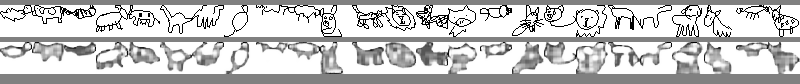

In [57]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))